##### Copyright 2024 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

    0/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


       0/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 8265728/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

17645568/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


   0/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


      0/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [4]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


I0000 00:00:1713230807.172583   14227 service.cc:145] XLA service 0x7fe4cc007e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713230807.172638   14227 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1713230807.172643   14227 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1713230807.172646   14227 service.cc:153]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1713230807.172648   14227 service.cc:153]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 45:40 1s/step - loss: 0.1727

  41/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1401  

  86/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1168

 131/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1034

I0000 00:00:1713230807.858362   14227 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 174/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0946

 218/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0879

 263/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0824

 308/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0781

 353/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0744

 397/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0713

 440/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0688

 484/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0664

 529/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0643

 574/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0624

 618/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0608

 662/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0592

 705/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0579

 750/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0566

 794/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0554

 839/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0542

 883/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0532

 927/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0522

 971/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0513

1016/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0505

1060/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0496

1106/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0488

1151/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0481

1197/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0474

1242/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0467

1287/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0461

1332/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0455

1377/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0449

1422/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0443

1467/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0438

1512/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0433

1556/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0428

1602/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0423

1647/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0418

1692/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0414

1737/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0410

1781/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0406

1826/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0402

1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0398

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0397 - val_loss: 0.0134


Epoch 2/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:31 49ms/step - loss: 0.0135

  45/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0137   

  89/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0136

 135/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0135

 182/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0134

 229/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133

 275/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133

 321/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132

 367/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132

 414/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132

 460/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131

 506/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131

 552/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131

 598/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130

 644/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130

 690/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130

 736/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129

 782/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129

 828/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129

 875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129

 922/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128

 968/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128

1014/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128

1058/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128

1102/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127

1144/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127

1188/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127

1233/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127

1278/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127

1324/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

1370/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

1415/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

1460/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

1505/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

1551/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1597/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1643/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1688/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1733/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1778/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1824/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124

1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0124 - val_loss: 0.0111


Epoch 3/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0121

  43/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0106   

  86/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0106

 129/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0105

 170/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0105

 213/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105

 256/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105

 299/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105

 342/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105

 385/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105

 428/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105

 471/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 514/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 557/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 599/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 640/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 682/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 724/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 765/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 807/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 849/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 891/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 933/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 975/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

1016/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

1059/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1102/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1145/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1186/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1229/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1271/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1314/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1356/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1398/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1441/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1484/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1527/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1569/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1611/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1652/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1698/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1744/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1790/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1834/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0102 - val_loss: 0.0097


Epoch 4/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:30 48ms/step - loss: 0.0102

  45/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0093   

  89/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0094

 134/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094

 180/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 226/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 272/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 318/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 365/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 411/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 457/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 503/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 549/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 594/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 639/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 685/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 731/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 777/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 824/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 871/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 917/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 964/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

1010/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1055/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1100/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1146/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1193/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1239/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1286/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1333/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1380/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1426/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1472/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1518/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1564/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1610/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1656/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1702/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1748/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1793/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0095 - val_loss: 0.0094


Epoch 5/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:30 48ms/step - loss: 0.0097

  44/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0093   

  88/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0093

 133/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 177/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 221/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 266/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 312/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 359/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 405/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 452/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 498/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 544/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 590/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 637/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 682/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 727/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 772/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 816/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 862/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 907/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 953/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093

 996/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1041/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1086/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1131/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1177/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1223/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1268/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1313/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1358/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1403/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1448/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1493/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1538/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1583/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1629/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1675/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1720/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1766/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1811/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092 - val_loss: 0.0092


Epoch 6/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:31 49ms/step - loss: 0.0084

  46/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0090   

  94/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 141/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 187/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 234/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 281/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091

 328/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091

 375/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091

 422/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 470/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 516/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 560/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 605/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 651/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 695/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 737/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 782/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 827/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 873/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 917/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 960/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

1004/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1047/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1093/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1139/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1182/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1225/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1268/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1311/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1353/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1397/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1438/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1481/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1525/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1568/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1611/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1654/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1698/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1742/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1788/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1833/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0090 - val_loss: 0.0090


Epoch 7/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0089

  44/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089   

  88/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088

 132/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088

 175/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 218/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 263/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 308/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 353/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 400/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 447/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 494/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 540/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 586/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 632/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 679/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 725/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 772/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 818/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 866/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 914/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 963/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

1010/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1057/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1104/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1150/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1197/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1245/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1293/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1340/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1386/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1433/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1481/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1527/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1573/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1620/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1667/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1715/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089

1763/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089

1811/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089

1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089 - val_loss: 0.0089


Epoch 8/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:30 48ms/step - loss: 0.0076

  45/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088   

  92/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 138/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 184/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 229/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 275/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 320/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 365/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 409/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 454/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 500/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 546/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 592/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 639/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 686/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 733/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 780/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 828/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 924/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 971/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1019/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1066/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1113/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1161/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1208/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1252/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1297/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1343/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1389/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1436/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1483/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1529/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1575/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1622/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1669/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1715/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1760/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1806/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088 - val_loss: 0.0090


Epoch 9/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:31 49ms/step - loss: 0.0094

  45/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087   

  91/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087

 137/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 183/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 229/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 275/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 321/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 367/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 413/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 459/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 504/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 549/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 594/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 639/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 684/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 731/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 777/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 822/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 868/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 913/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 959/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

1005/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1051/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1097/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1142/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1187/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1233/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1279/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1326/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1373/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1420/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1466/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1512/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1559/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1606/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1653/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1700/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1746/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1793/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087 - val_loss: 0.0089


Epoch 10/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0082

  46/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0085   

  91/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0085

 136/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 180/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 226/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 271/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 317/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 363/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 410/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 455/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 500/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 545/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 590/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 635/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 680/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 724/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 770/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 815/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 860/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 906/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 951/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 996/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1041/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1085/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1131/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1176/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1221/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1266/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1311/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1357/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1403/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1449/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1494/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1539/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1585/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1631/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1676/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1721/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1766/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1811/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087 - val_loss: 0.0088


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

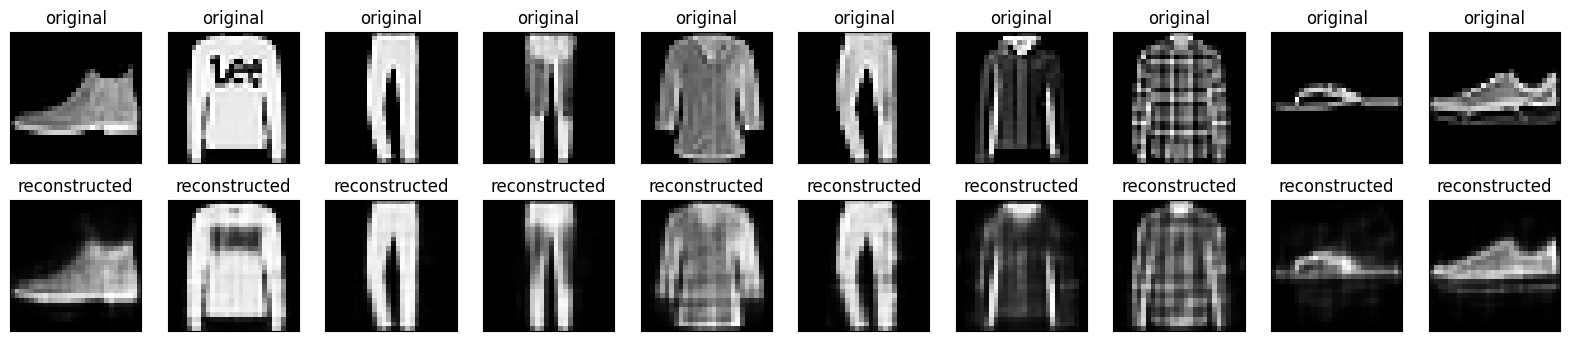

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


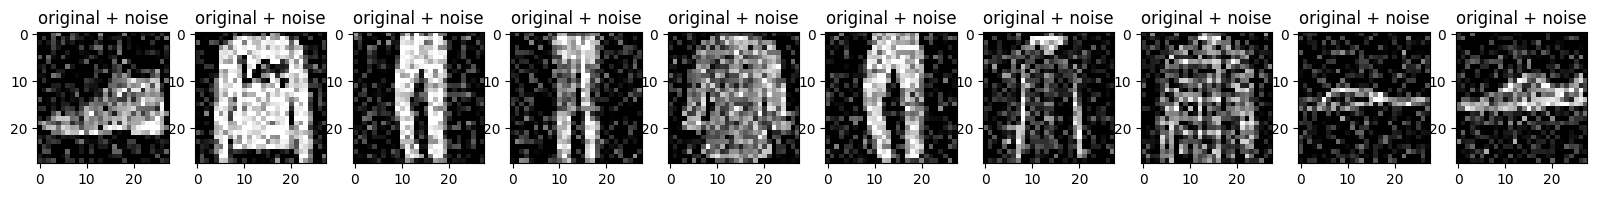

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:36:44 3s/step - loss: 0.1659

  31/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1661    

  64/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1552

  97/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1392

 130/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1254

 163/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1144

 197/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1052

 230/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0979

 264/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0917

 298/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0864

 332/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0819

 365/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0781

 399/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0746

 433/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0715

 467/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0688

 500/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0664

 533/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0642

 568/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0621

 603/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0601

 638/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0584

 673/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0568

 707/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0553

 741/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0539

 775/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0527

 808/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0515

 841/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0504

 874/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0494

 907/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0485

 940/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0476

 973/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0467

1006/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0459

1039/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0451

1072/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0444

1105/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0437

1138/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0430

1171/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0423

1204/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0417

1237/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0411

1270/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0406

1302/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0401

1335/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0395

1368/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0390

1401/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0385

1434/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0381

1467/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0376

1500/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0372

1533/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0368

1565/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0364

1597/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0360

1630/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356

1663/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0353

1696/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0349

1728/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0346

1760/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343

1792/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339

1825/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0336

1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0333

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0332 - val_loss: 0.0094


Epoch 2/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0083

  33/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092   

  65/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

  97/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 129/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 161/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 193/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 225/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 257/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 289/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 322/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 355/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 387/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 419/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092

 452/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092

 485/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092

 517/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092

 549/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092

 581/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092

 613/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092

 645/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092

 678/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092

 711/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092

 744/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092

 776/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092

 809/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092

 842/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

 875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

 907/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

 939/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

 972/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

1005/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

1037/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

1069/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

1101/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

1132/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

1164/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

1196/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

1227/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091

1258/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091

1289/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091

1320/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1352/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1384/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1415/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1447/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1479/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1510/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1541/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1572/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1604/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1634/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1665/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1696/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1727/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1758/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1789/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1820/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090

1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0089 - val_loss: 0.0081


Epoch 3/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0085

  31/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080   

  60/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080

  89/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080

 118/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080

 148/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 178/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 208/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 238/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 267/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 297/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 328/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 358/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 388/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 418/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 448/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 478/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 508/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 537/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 566/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 596/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 625/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 655/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 685/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 715/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080

 744/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080

 774/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080

 804/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080

 834/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 864/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 894/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 924/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 954/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 984/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1014/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1044/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1074/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1104/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1134/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1164/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1194/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1224/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1253/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1282/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1311/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1340/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1369/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1398/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1427/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1455/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1484/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1513/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1543/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1573/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1603/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1632/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1662/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1691/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1720/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1749/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1780/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1809/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0079 - val_loss: 0.0076


Epoch 4/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:30 48ms/step - loss: 0.0074

  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0074   

  58/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0074

  87/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0074

 116/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0074

 146/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0074

 175/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0074

 204/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0074

 234/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0074

 264/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0074

 294/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0074

 324/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 354/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 384/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 414/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 445/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 475/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 505/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 535/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 566/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 596/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 626/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 657/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 688/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075

 719/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

 750/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

 780/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

 810/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

 841/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

 872/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

 903/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

 934/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

 964/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

 995/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1026/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1057/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1088/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1118/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1149/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1180/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1210/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1240/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1270/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075

1300/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1329/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1358/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1387/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1415/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1444/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1475/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1506/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1536/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1566/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1596/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1626/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1656/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1686/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075

1716/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074

1746/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074

1776/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074

1806/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074

1837/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074

1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0074 - val_loss: 0.0073


Epoch 5/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:33 50ms/step - loss: 0.0075

  28/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072   

  55/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072

  82/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072

 110/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072

 138/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072

 166/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072

 194/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072

 222/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072

 250/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 278/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 306/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 334/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 362/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 390/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 418/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 446/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 474/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 502/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 530/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 558/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 586/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 615/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 643/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 671/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 700/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 729/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 757/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072

 785/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

 814/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

 843/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

 872/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

 902/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

 931/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

 961/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

 991/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1021/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1050/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1079/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1108/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1137/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1165/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1194/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1222/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1250/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1279/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1307/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072

1336/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1364/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1393/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1422/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1451/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1481/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1511/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1542/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1572/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1602/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1632/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1663/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1693/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1723/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1753/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1784/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1814/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0072 - val_loss: 0.0071


Epoch 6/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0062

  31/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069   

  61/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070

  91/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070

 121/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 151/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 181/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 211/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 241/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 271/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 301/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 330/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 359/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 388/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 416/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 445/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 475/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 505/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 533/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 561/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 590/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 620/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 650/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 680/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 710/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 740/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

 770/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

 800/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

 829/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

 859/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

 889/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

 918/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

 947/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

 977/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1006/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1036/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1066/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1096/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1126/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1156/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1186/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1215/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1245/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1274/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070

1304/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1334/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1364/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1394/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1424/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1454/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1483/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1512/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1541/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1571/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1601/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1631/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1660/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1689/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1717/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1745/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1774/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1802/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1831/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0070 - val_loss: 0.0070


Epoch 7/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:32 50ms/step - loss: 0.0077

  29/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0068   

  58/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069

  87/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069

 117/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069

 146/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069

 175/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 204/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 233/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 262/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 291/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 320/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 350/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 380/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 410/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 440/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 470/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 500/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 530/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 559/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 589/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 619/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 649/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 679/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 709/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 739/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

 768/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

 797/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

 827/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

 857/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

 886/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

 914/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

 943/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

 972/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1000/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1029/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1058/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1086/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1115/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1146/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1176/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1205/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1234/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1262/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1291/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069

1320/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1348/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1376/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1404/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1432/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1460/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1488/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1516/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1545/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1573/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1601/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1630/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1659/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1688/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1717/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1746/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1775/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1803/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1832/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0069 - val_loss: 0.0069


Epoch 8/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:33 50ms/step - loss: 0.0059

  29/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0068   

  57/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0068

  85/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0068

 114/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0068

 143/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0068

 172/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0068

 202/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 231/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 260/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 290/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 319/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 348/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 377/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 407/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 437/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 467/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 497/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 527/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 557/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 587/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 617/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 647/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 677/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 707/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 738/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 769/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 799/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 829/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 859/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 889/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 919/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 949/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 979/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1009/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1039/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1069/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1099/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1130/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1160/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1190/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1220/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1250/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1280/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1310/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1340/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1370/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1400/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1430/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1461/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1491/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1521/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1551/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1580/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1608/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1636/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1664/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1693/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1721/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1750/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1779/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1808/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1837/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0068 - val_loss: 0.0068


Epoch 9/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:31 49ms/step - loss: 0.0075

  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0071   

  60/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070

  89/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070

 119/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069

 148/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 177/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 206/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 235/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 264/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 293/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 323/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 352/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 381/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 410/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 439/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 467/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 496/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 525/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 555/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 584/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 613/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 642/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 671/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 700/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 729/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 757/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 785/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 815/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 844/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 873/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 903/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 933/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 962/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 991/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1020/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1050/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1080/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1110/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1140/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1169/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1199/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1229/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1258/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1286/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1315/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1345/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1374/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1404/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1434/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1464/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1494/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1524/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1554/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1584/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1614/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1644/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1674/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1705/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1736/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1767/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1798/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1829/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0068 - val_loss: 0.0067


Epoch 10/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:31 49ms/step - loss: 0.0065

  32/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070   

  63/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

  94/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070

 125/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 156/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 187/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 218/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 249/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 280/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 312/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069

 343/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 374/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 405/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 436/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 468/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 499/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 530/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 561/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 592/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 623/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068

 655/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 687/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 718/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 749/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 780/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 811/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 842/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 873/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 904/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 935/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 965/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

 996/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1027/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1058/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1089/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1119/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1149/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1180/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1211/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1241/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068

1271/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1302/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1334/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1365/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1396/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1427/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1459/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1491/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1522/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1553/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1584/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1615/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1646/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068

1677/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067

1708/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067

1739/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067

1770/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067

1801/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067

1832/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067

1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0067 - val_loss: 0.0067


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

The decoder upsamples the images back from 7x7 to 28x28.

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (32, 14, 14, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (32, 28, 28, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 28, 28, 1)        │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [18]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

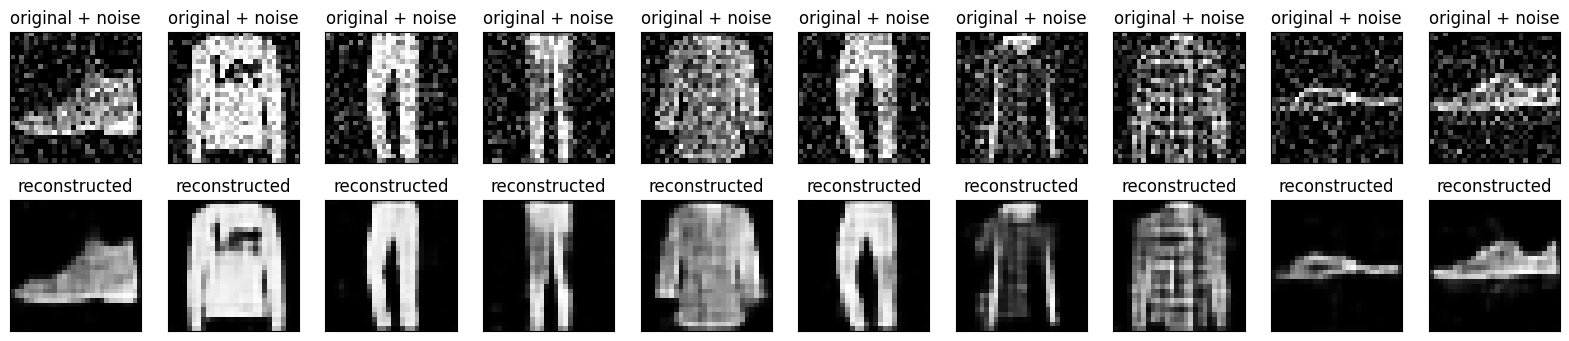

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

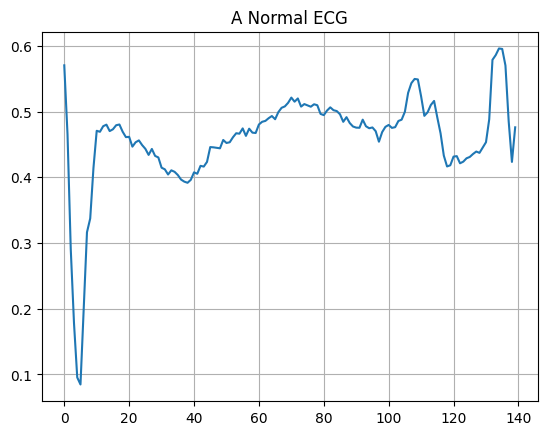

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

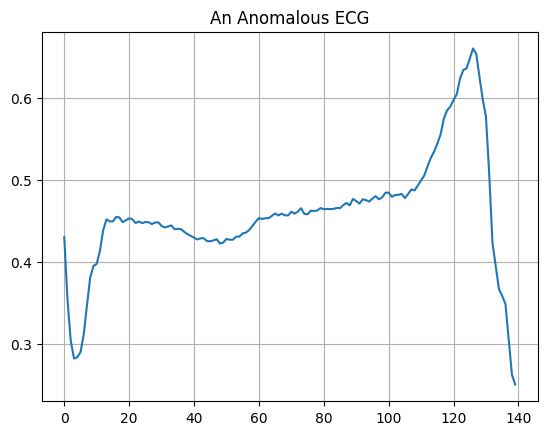

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 0.0581

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.0576

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - loss: 0.0575 - val_loss: 0.0526


Epoch 2/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0556

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0549 - val_loss: 0.0506


Epoch 3/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0523

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0514 - val_loss: 0.0488


Epoch 4/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0483

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0475 - val_loss: 0.0466


Epoch 5/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0443

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0432 - val_loss: 0.0439


Epoch 6/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0401

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0389 - val_loss: 0.0421


Epoch 7/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0360

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0353 - val_loss: 0.0404


Epoch 8/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0327

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0319 - val_loss: 0.0388


Epoch 9/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0288

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0290 - val_loss: 0.0374


Epoch 10/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0278

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0276 - val_loss: 0.0368


Epoch 11/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0270

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0264 - val_loss: 0.0363


Epoch 12/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0255

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0254 - val_loss: 0.0356


Epoch 13/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0242

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0242 - val_loss: 0.0352


Epoch 14/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0237

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0234 - val_loss: 0.0350


Epoch 15/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0233

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0229 - val_loss: 0.0345


Epoch 16/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0222

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0222 - val_loss: 0.0343


Epoch 17/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0220

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0216 - val_loss: 0.0341


Epoch 18/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0213

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0212 - val_loss: 0.0338


Epoch 19/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0214

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0210 - val_loss: 0.0338


Epoch 20/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0211

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0208 - val_loss: 0.0339


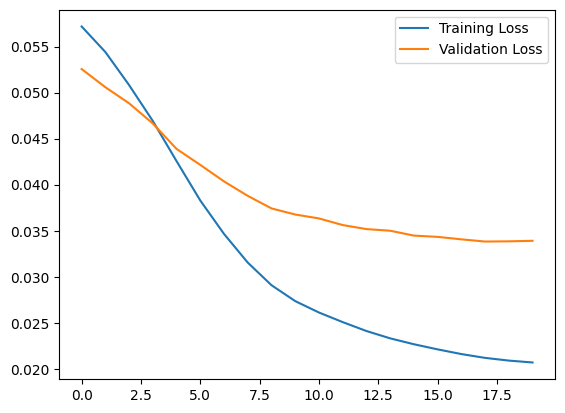

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

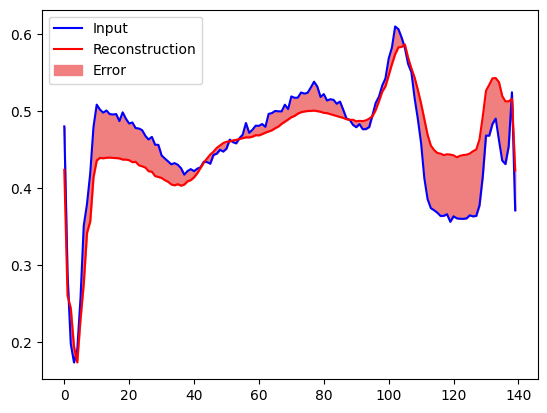

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

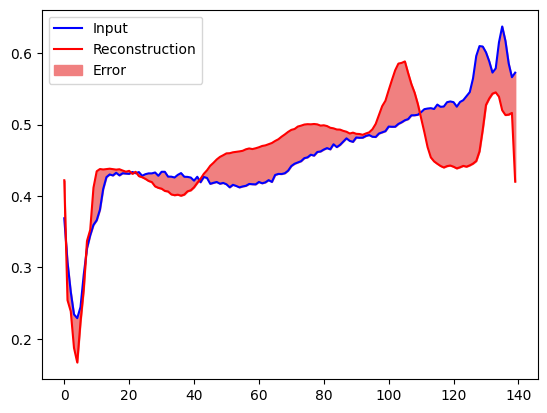

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

 1/74 ━━━━━━━━━━━━━━━━━━━━ 32s 439ms/step

48/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


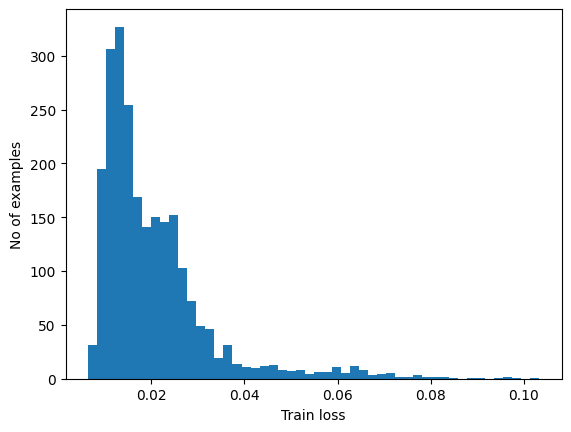

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033047937


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


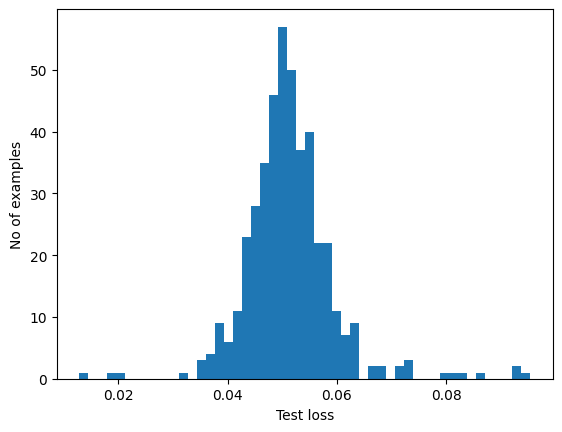

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571


## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
